# Uncertainty for a Synthetic Regression Task using probly

This notebook gives an example for quantifying uncertainty in a synthetic regression setting using the setup from Valdenegro-Toro et al. (2022). Paper: https://arxiv.org/abs/2204.09308

In [75]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

### Generate Synthetic Data
Generate a synthetic data set based on a sinusoidal function. Sample data points (x) uniformly between 0 and 10 and generate labels based on the function. Create training data, test data and out of distribution data (x between 10 and 15).

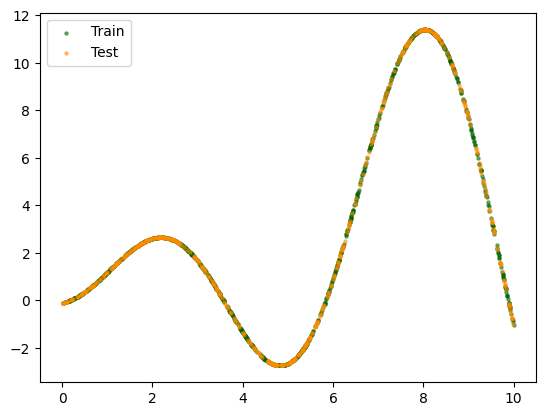

In [76]:
eps1 = np.random.normal(0, 0.3)
eps2 = np.random.normal(0, 0.3)
# Generate data points between 0 and 10
X = np.expand_dims(np.random.uniform(0, 10, 1500), axis=1)
X_train = X[:1000]
X_test = X[1000:]
# Generate ood data points between 10 and 15
X_ood = np.expand_dims(np.random.uniform(10, 15, 200), axis=1)
# Generate labels
y = X * np.sin(X) + eps1 * X + eps2
y_train = y[:1000]
y_test = y[1000:]

# create data loaders
batch_size = 32
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)), batch_size=batch_size, shuffle=False)

# plot data
plt.scatter(X_train[:, 0], y_train[:, 0], c='darkgreen', s=5, alpha=0.5, label='Train')
plt.scatter(X_test[:, 0], y_test[:, 0], c='darkorange', s=5, alpha=0.5, label='Test')
plt.legend()
plt.show()

### Create Dropout Model
Create a simple neural network and transform it to a Dropout model using probly.

In [90]:
from probly.representation.dropout import Dropout

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc31 = nn.Linear(32, 1)
        self.fc32 = nn.Linear(32, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        mu = self.fc31(x)
        sigma2 = F.softplus(self.fc32(x))
        x = torch.cat([mu, sigma2], dim=1)
        return x

net = Net()
# transform model to a Dropout model
model = Dropout(net)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.GaussianNLLLoss()

### Train Dropout Model
Train the Dropout model based on the training data, the given loss (criterion) and optimizer.

In [91]:
epochs = 700

for _ in tqdm(range(epochs)):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs, 1)
        mean = outputs[:, :, 0]
        var = outputs[:, :, 1]
        loss = criterion(mean, targets, var)
        loss.backward()
        optimizer.step()
model.eval()

  0%|          | 0/700 [00:00<?, ?it/s]


TypeError: MSELoss.forward() takes 3 positional arguments but 4 were given

### Evaluation
Evaluate model performance and uncertainty behavior for the test and ood data points.

(500, 100, 2) (200, 1) (200, 2) (500,) (500,) (500,)


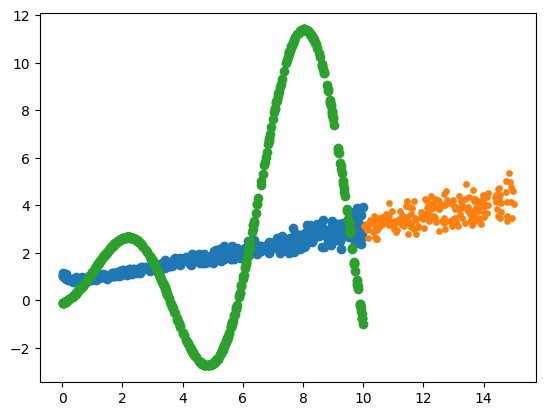

In [89]:
from probly.quantification.regression import total_uncertainty_variance, aleatoric_uncertainty_variance, epistemic_uncertainty_variance

y_pred = model(torch.from_numpy(X_test).float(), 100).detach().cpu().numpy()
y_pred_ood = model(torch.from_numpy(X_ood).float(), 100).detach().cpu().numpy()

# evaluate model performance

# evaluate uncertainty
tu = total_uncertainty_variance(y_pred)
au = aleatoric_uncertainty_variance(y_pred)
eu = epistemic_uncertainty_variance(y_pred)

print(y_pred.shape, X_ood.shape, y_pred_ood.mean(axis=1).shape, tu.shape, au.shape, eu.shape)
# plot results
plt.scatter(X_test[:, 0], y_pred.mean(axis=1)[:, 0])
plt.scatter(X_ood[:, 0], y_pred_ood.mean(axis=1)[:, 0], s=15)
plt.scatter(X_test[:, 0], y_test[:, 0])